In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


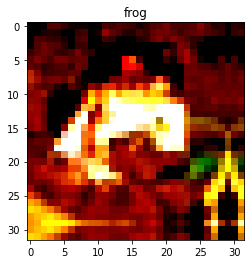

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
       


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [4, 5, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4992586


In [ ]:
num_epochs = 5000 # param
epoch_start = 0
path = 'batch_256_lr_0.1-0.0001_no_crop_decay_0.0001_block_453.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

Loss = torch.nn.CrossEntropyLoss()
lr = 0.1 # param
lr_min=0.0001
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
# optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimizer
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov,weight_decay=0.0001)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 115
Epoch 116, Train loss 0.047764037859303, Test loss 0.29489770010113714, Train accuracy 98.37452168367346, Test accuracy 92.12890625, Cost 75.64219212532043 s
Epoch 117, Train loss 0.04924534355784405, Test loss 0.3131754320114851, Train accuracy 98.35379464285714, Test accuracy 91.494140625, Cost 75.92839646339417 s
Epoch 118, Train loss 0.050658419885083426, Test loss 0.3197927627712488, Train accuracy 98.30875318877551, Test accuracy 91.7578125, Cost 75.811368227005 s
Epoch 119, Train loss 0.05690795008796362, Test loss 0.2726452466100454, Train accuracy 98.04368622448979, Test accuracy 92.529296875, Cost 75.88377404212952 s
Epoch 120, Train loss 0.049781128555080115, Test loss 0.29651038348674774, Train accuracy 98.35538903061224, Test accuracy 92.041015625, Cost 75.76727533340454 s
Model saved in epoch 120
Epoch 121, Train loss 0.04283033530417906, Test loss 0.29860147945582866, Train accuracy 98.55747767857143, Test accuracy 91.914

Epoch 166, Train loss 0.040432098162436515, Test loss 0.31690364368259905, Train accuracy 98.62165178571429, Test accuracy 92.24609375, Cost 75.59203267097473 s
Epoch 167, Train loss 0.04784861298239961, Test loss 0.2849147267639637, Train accuracy 98.37611607142857, Test accuracy 92.275390625, Cost 75.43741726875305 s
Epoch 168, Train loss 0.041594219940467456, Test loss 0.29710172265768053, Train accuracy 98.54472257653062, Test accuracy 92.041015625, Cost 75.60161137580872 s
Epoch 169, Train loss 0.04384150793205718, Test loss 0.2705798912793398, Train accuracy 98.47417091836735, Test accuracy 92.75390625, Cost 75.29907536506653 s
Epoch 170, Train loss 0.040909512538690955, Test loss 0.3062034878879786, Train accuracy 98.6264349489796, Test accuracy 92.20703125, Cost 75.6327052116394 s
Model saved in epoch 170
Epoch 171, Train loss 0.04501934033552451, Test loss 0.3053544994443655, Train accuracy 98.46699617346938, Test accuracy 91.865234375, Cost 75.51141548156738 s
Epoch 172, Trai

Epoch 216, Train loss 0.043507283767305165, Test loss 0.2877269022166729, Train accuracy 98.51682079081633, Test accuracy 92.5, Cost 75.85556483268738 s
Epoch 217, Train loss 0.039168655482710014, Test loss 0.29640592746436595, Train accuracy 98.66509885204081, Test accuracy 92.40234375, Cost 75.49577307701111 s
Epoch 218, Train loss 0.03922841495036015, Test loss 0.2975390736013651, Train accuracy 98.68183992346938, Test accuracy 92.509765625, Cost 75.85364770889282 s
Epoch 219, Train loss 0.04382117924147418, Test loss 0.28739467430859805, Train accuracy 98.49330357142857, Test accuracy 92.255859375, Cost 75.68708825111389 s
Epoch 220, Train loss 0.04140303240689848, Test loss 0.28597537986934185, Train accuracy 98.61846301020408, Test accuracy 92.451171875, Cost 75.664479970932 s
Model saved in epoch 220
Epoch 221, Train loss 0.04461752896539259, Test loss 0.2973561864346266, Train accuracy 98.56584821428571, Test accuracy 92.451171875, Cost 75.74618911743164 s
Epoch 222, Train loss

Epoch 266, Train loss 0.042282726634673924, Test loss 0.3010497882962227, Train accuracy 98.52917729591837, Test accuracy 92.34375, Cost 75.79675722122192 s
Epoch 267, Train loss 0.034240974316478004, Test loss 0.26218626499176023, Train accuracy 98.9014668367347, Test accuracy 93.14453125, Cost 75.58971309661865 s
Epoch 268, Train loss 0.0366554244145827, Test loss 0.2875853803008795, Train accuracy 98.75358737244898, Test accuracy 92.294921875, Cost 75.99845600128174 s
Epoch 269, Train loss 0.043426304784774473, Test loss 0.26795142889022827, Train accuracy 98.51442920918367, Test accuracy 93.2421875, Cost 75.80076622962952 s
Epoch 270, Train loss 0.037239500953416736, Test loss 0.2930745258927345, Train accuracy 98.73246173469387, Test accuracy 92.822265625, Cost 75.65532541275024 s
Model saved in epoch 270
Epoch 271, Train loss 0.034035536824079345, Test loss 0.27761837989091875, Train accuracy 98.86599170918367, Test accuracy 92.6171875, Cost 75.88598299026489 s
Epoch 272, Train l

Epoch 316, Train loss 0.034743939179508965, Test loss 0.2818708211183548, Train accuracy 98.78985969387755, Test accuracy 92.3046875, Cost 75.92866539955139 s
Epoch 317, Train loss 0.036241626426368495, Test loss 0.264738592132926, Train accuracy 98.81178252551021, Test accuracy 93.369140625, Cost 75.87530875205994 s
Epoch 318, Train loss 0.0342600756320076, Test loss 0.25975172631442545, Train accuracy 98.89748086734694, Test accuracy 93.41796875, Cost 75.75210762023926 s
Epoch 319, Train loss 0.03533744801558098, Test loss 0.28521725088357924, Train accuracy 98.7679368622449, Test accuracy 92.7734375, Cost 75.74856376647949 s
Epoch 320, Train loss 0.039948129912420194, Test loss 0.2622391559183598, Train accuracy 98.63879145408163, Test accuracy 93.154296875, Cost 75.54170799255371 s
Model saved in epoch 320
Epoch 321, Train loss 0.033325684791411826, Test loss 0.27024321667850015, Train accuracy 98.87515943877551, Test accuracy 93.466796875, Cost 75.80026531219482 s
Epoch 322, Train

Epoch 366, Train loss 0.03865330735440081, Test loss 0.28736845664680005, Train accuracy 98.69579081632654, Test accuracy 92.392578125, Cost 75.50923538208008 s
Epoch 367, Train loss 0.03329578767131482, Test loss 0.28470880538225174, Train accuracy 98.93574617346938, Test accuracy 92.91015625, Cost 75.79774165153503 s
Epoch 368, Train loss 0.0337666761324912, Test loss 0.3125379979610443, Train accuracy 98.90744579081633, Test accuracy 92.255859375, Cost 75.708505153656 s
Epoch 369, Train loss 0.03878487890814336, Test loss 0.2679761152714491, Train accuracy 98.66390306122449, Test accuracy 92.79296875, Cost 75.81094932556152 s
Epoch 370, Train loss 0.03839987460808943, Test loss 0.25878120213747025, Train accuracy 98.66948341836735, Test accuracy 93.056640625, Cost 75.72088527679443 s
Model saved in epoch 370
Epoch 371, Train loss 0.037657272538683395, Test loss 0.2773787423968315, Train accuracy 98.75039859693878, Test accuracy 92.3046875, Cost 75.56398749351501 s
Epoch 372, Train l

Epoch 416, Train loss 0.040900566025960206, Test loss 0.256399754062295, Train accuracy 98.63480548469387, Test accuracy 93.26171875, Cost 75.31435465812683 s
Epoch 417, Train loss 0.03189783320733707, Test loss 0.2706993013620377, Train accuracy 98.95687181122449, Test accuracy 93.017578125, Cost 75.51526093482971 s
Epoch 418, Train loss 0.030348064121315067, Test loss 0.3053957249969244, Train accuracy 98.99154974489795, Test accuracy 91.62109375, Cost 75.85543179512024 s
Epoch 419, Train loss 0.042043461749444205, Test loss 0.24802042115479708, Train accuracy 98.62603635204081, Test accuracy 93.203125, Cost 75.79768824577332 s
Epoch 420, Train loss 0.034423902825623444, Test loss 0.2591162759810686, Train accuracy 98.79942602040816, Test accuracy 93.14453125, Cost 75.76021552085876 s
Model saved in epoch 420
Epoch 421, Train loss 0.038126654595098626, Test loss 0.2719386428594589, Train accuracy 98.7352519132653, Test accuracy 92.666015625, Cost 75.68507742881775 s
Epoch 422, Train 

Epoch 466, Train loss 0.03175795852558269, Test loss 0.2941706568002701, Train accuracy 98.90306122448979, Test accuracy 92.822265625, Cost 75.77828478813171 s
Epoch 467, Train loss 0.040526343150805604, Test loss 0.27856543753296137, Train accuracy 98.67625956632654, Test accuracy 92.98828125, Cost 75.64475607872009 s
Epoch 468, Train loss 0.03110723041131028, Test loss 0.2748332928866148, Train accuracy 98.95089285714286, Test accuracy 92.578125, Cost 75.6219413280487 s
Epoch 469, Train loss 0.031392907395920884, Test loss 0.2807304300367832, Train accuracy 99.01068239795919, Test accuracy 92.919921875, Cost 75.63950943946838 s
Epoch 470, Train loss 0.03768022503342708, Test loss 0.27720476500689983, Train accuracy 98.75956632653062, Test accuracy 92.646484375, Cost 75.73279905319214 s
Model saved in epoch 470
Epoch 471, Train loss 0.03259756780533614, Test loss 0.2778427843004465, Train accuracy 98.89947385204081, Test accuracy 93.125, Cost 75.9215145111084 s
Epoch 472, Train loss 0

Epoch 516, Train loss 0.032263182806877455, Test loss 0.2925595950335264, Train accuracy 98.91342474489795, Test accuracy 92.6953125, Cost 75.91584920883179 s
Epoch 517, Train loss 0.03442965247383227, Test loss 0.2748568098992109, Train accuracy 98.84406887755102, Test accuracy 92.91015625, Cost 75.71351718902588 s
Epoch 518, Train loss 0.03132118216991348, Test loss 0.27244125083088877, Train accuracy 98.9991230867347, Test accuracy 92.98828125, Cost 75.89204025268555 s
Epoch 519, Train loss 0.03653838233404546, Test loss 0.27687571533024313, Train accuracy 98.77630739795919, Test accuracy 93.1640625, Cost 75.88379311561584 s
Epoch 520, Train loss 0.03249243940986997, Test loss 0.2779064401984215, Train accuracy 98.88472576530613, Test accuracy 92.802734375, Cost 75.74017000198364 s
Model saved in epoch 520
Epoch 521, Train loss 0.037013670823973964, Test loss 0.25765073895454405, Train accuracy 98.69419642857143, Test accuracy 93.017578125, Cost 75.91650128364563 s
Epoch 522, Train 

Epoch 566, Train loss 0.03017816097922243, Test loss 0.26308797523379324, Train accuracy 99.01506696428571, Test accuracy 92.998046875, Cost 75.87566304206848 s
Epoch 567, Train loss 0.031068879006221434, Test loss 0.3042314939200878, Train accuracy 98.98038903061224, Test accuracy 92.3828125, Cost 75.70821261405945 s
Epoch 568, Train loss 0.03411243109232081, Test loss 0.29726110547780993, Train accuracy 98.89947385204081, Test accuracy 92.919921875, Cost 75.88614749908447 s
Epoch 569, Train loss 0.03461312016054076, Test loss 0.2726694967597723, Train accuracy 98.81935586734694, Test accuracy 92.666015625, Cost 75.76475358009338 s
Epoch 570, Train loss 0.03526372707933568, Test loss 0.2623360872268677, Train accuracy 98.82413903061224, Test accuracy 93.310546875, Cost 75.63479280471802 s
Model saved in epoch 570
Epoch 571, Train loss 0.031499348421657115, Test loss 0.25951538383960726, Train accuracy 98.94172512755102, Test accuracy 92.978515625, Cost 75.91190314292908 s
Epoch 572, T

Epoch 616, Train loss 0.029424258576687044, Test loss 0.2862532392144203, Train accuracy 98.97680165816327, Test accuracy 92.568359375, Cost 77.1339681148529 s
Epoch 617, Train loss 0.03530436959022618, Test loss 0.3114698242396116, Train accuracy 98.86798469387755, Test accuracy 92.294921875, Cost 77.07748889923096 s
Epoch 618, Train loss 0.03179670848446537, Test loss 0.25534350126981736, Train accuracy 98.93534757653062, Test accuracy 93.14453125, Cost 76.96671891212463 s
Epoch 619, Train loss 0.032105899377897075, Test loss 0.28239317834377287, Train accuracy 98.89947385204081, Test accuracy 92.919921875, Cost 77.26965475082397 s
Epoch 620, Train loss 0.033733249145407915, Test loss 0.2602066475898027, Train accuracy 98.87994260204081, Test accuracy 93.076171875, Cost 76.87896537780762 s
Model saved in epoch 620
Epoch 621, Train loss 0.033102130360559236, Test loss 0.2752646539360285, Train accuracy 98.92936862244898, Test accuracy 92.763671875, Cost 76.88491487503052 s
Epoch 622, 

Epoch 666, Train loss 0.0335888787034937, Test loss 0.3001024216413498, Train accuracy 98.85722257653062, Test accuracy 92.59765625, Cost 75.69923663139343 s
Epoch 667, Train loss 0.03485150704854073, Test loss 0.2533381974324584, Train accuracy 98.86918048469387, Test accuracy 93.388671875, Cost 75.47162652015686 s
Epoch 668, Train loss 0.034575216491155476, Test loss 0.2652542918920517, Train accuracy 98.8233418367347, Test accuracy 93.26171875, Cost 75.65686583518982 s
Epoch 669, Train loss 0.02820048094204418, Test loss 0.2733714960515499, Train accuracy 99.06489158163265, Test accuracy 92.939453125, Cost 75.46318340301514 s
Epoch 670, Train loss 0.027250122507007753, Test loss 0.29842630960047245, Train accuracy 99.08282844387755, Test accuracy 92.822265625, Cost 75.7887852191925 s
Model saved in epoch 670
Epoch 671, Train loss 0.0313074468012557, Test loss 0.29181669279932976, Train accuracy 98.96524234693878, Test accuracy 92.65625, Cost 75.68793487548828 s
Epoch 672, Train loss

Epoch 716, Train loss 0.02860100668550906, Test loss 0.27861443907022476, Train accuracy 99.02861926020408, Test accuracy 92.880859375, Cost 75.99797129631042 s
Epoch 717, Train loss 0.03269267083639849, Test loss 0.28534182384610174, Train accuracy 98.96285076530613, Test accuracy 92.67578125, Cost 75.52316427230835 s
Epoch 718, Train loss 0.03120181473608756, Test loss 0.2776524156332016, Train accuracy 98.92897002551021, Test accuracy 92.802734375, Cost 75.82069373130798 s
Epoch 719, Train loss 0.031834800409305156, Test loss 0.27429681830108166, Train accuracy 98.95129145408163, Test accuracy 92.900390625, Cost 75.85108494758606 s
Epoch 720, Train loss 0.027576501793655738, Test loss 0.25768398866057396, Train accuracy 99.11710778061224, Test accuracy 93.271484375, Cost 75.80673170089722 s
Model saved in epoch 720
Epoch 721, Train loss 0.027733417063932484, Test loss 0.27176283560693265, Train accuracy 99.08282844387755, Test accuracy 93.10546875, Cost 75.86801719665527 s
Epoch 722

Epoch 766, Train loss 0.026780996882660807, Test loss 0.2777185756713152, Train accuracy 99.13265306122449, Test accuracy 93.203125, Cost 76.05789399147034 s
Epoch 767, Train loss 0.028752372362555897, Test loss 0.2644325438886881, Train accuracy 99.07605229591837, Test accuracy 93.125, Cost 76.03606176376343 s
Epoch 768, Train loss 0.03606932818395447, Test loss 0.2641753315925598, Train accuracy 98.82613201530613, Test accuracy 92.91015625, Cost 75.82641315460205 s
Epoch 769, Train loss 0.03016918604333448, Test loss 0.3036514677107334, Train accuracy 99.04017857142857, Test accuracy 92.4609375, Cost 75.88045620918274 s
Epoch 770, Train loss 0.028880508139026255, Test loss 0.26286668702960014, Train accuracy 99.06449298469387, Test accuracy 93.291015625, Cost 75.77115201950073 s
Model saved in epoch 770
Epoch 771, Train loss 0.02879643633876148, Test loss 0.27408622615039346, Train accuracy 99.0413743622449, Test accuracy 92.958984375, Cost 75.9244704246521 s
Epoch 772, Train loss 0.

Epoch 816, Train loss 0.030267007656072323, Test loss 0.25606453232467175, Train accuracy 98.95487882653062, Test accuracy 93.095703125, Cost 75.84615635871887 s
Epoch 817, Train loss 0.02265710284463035, Test loss 0.27092277333140374, Train accuracy 99.25223214285714, Test accuracy 93.41796875, Cost 75.93950819969177 s
Epoch 818, Train loss 0.031638513088739495, Test loss 0.2552147384732962, Train accuracy 98.92976721938776, Test accuracy 93.3203125, Cost 76.00180172920227 s
Epoch 819, Train loss 0.033035249711841116, Test loss 0.2614264335483313, Train accuracy 98.84566326530613, Test accuracy 93.22265625, Cost 75.91561579704285 s
Epoch 820, Train loss 0.026591510314741457, Test loss 0.2669877752661705, Train accuracy 99.18048469387755, Test accuracy 92.6171875, Cost 75.92208123207092 s
Model saved in epoch 820
Epoch 821, Train loss 0.023626826931627428, Test loss 0.2654894331470132, Train accuracy 99.21077806122449, Test accuracy 93.466796875, Cost 75.77547407150269 s
Epoch 822, Tra

Epoch 866, Train loss 0.025213765574391096, Test loss 0.2958484947681427, Train accuracy 99.19842155612245, Test accuracy 92.734375, Cost 76.02666401863098 s
Epoch 867, Train loss 0.02645195527382347, Test loss 0.28554607629776, Train accuracy 99.12627551020408, Test accuracy 92.822265625, Cost 75.80588293075562 s
Epoch 868, Train loss 0.034825713333331655, Test loss 0.28838683255016806, Train accuracy 98.77232142857143, Test accuracy 92.91015625, Cost 76.06016182899475 s
Epoch 869, Train loss 0.029283492878193453, Test loss 0.27874431349337103, Train accuracy 99.05293367346938, Test accuracy 92.91015625, Cost 75.85338973999023 s
Epoch 870, Train loss 0.025282858381504004, Test loss 0.25058261938393117, Train accuracy 99.1585618622449, Test accuracy 93.125, Cost 76.22166085243225 s
Model saved in epoch 870
Epoch 871, Train loss 0.03173782923781522, Test loss 0.2646221112459898, Train accuracy 98.93773915816327, Test accuracy 93.076171875, Cost 76.17212557792664 s
Epoch 872, Train loss 

Epoch 916, Train loss 0.028569054792216997, Test loss 0.2961979143321514, Train accuracy 99.02064732142857, Test accuracy 93.095703125, Cost 75.86583352088928 s
Epoch 917, Train loss 0.028431222374950136, Test loss 0.27028103470802306, Train accuracy 99.00908801020408, Test accuracy 93.232421875, Cost 75.68586325645447 s
Epoch 918, Train loss 0.025033232437598765, Test loss 0.24719386771321297, Train accuracy 99.1944355867347, Test accuracy 93.7109375, Cost 76.06347060203552 s
Epoch 919, Train loss 0.029227415958600005, Test loss 0.25278881639242173, Train accuracy 99.05891262755102, Test accuracy 93.3203125, Cost 76.13899612426758 s
Epoch 920, Train loss 0.03231448584179185, Test loss 0.2779812622815371, Train accuracy 98.90545280612245, Test accuracy 93.046875, Cost 75.8863251209259 s
Model saved in epoch 920
Epoch 921, Train loss 0.03057174983301333, Test loss 0.24179742950946093, Train accuracy 99.02463329081633, Test accuracy 93.59375, Cost 76.03370428085327 s
Epoch 922, Train los

Epoch 968, Train loss 0.022990556417166123, Test loss 0.2863122945651412, Train accuracy 99.24027423469387, Test accuracy 93.359375, Cost 75.89147615432739 s
Epoch 969, Train loss 0.02827732241237346, Test loss 0.2813749682158232, Train accuracy 99.0967793367347, Test accuracy 92.98828125, Cost 75.86211800575256 s
Epoch 970, Train loss 0.029677018355720734, Test loss 0.281359625980258, Train accuracy 99.01068239795919, Test accuracy 92.87109375, Cost 75.89134693145752 s
Model saved in epoch 970
Epoch 971, Train loss 0.025924573239053086, Test loss 0.29727785997092726, Train accuracy 99.15896045918367, Test accuracy 92.744140625, Cost 75.69445943832397 s
Epoch 972, Train loss 0.03111833213752478, Test loss 0.2653029289096594, Train accuracy 98.94491390306122, Test accuracy 93.095703125, Cost 75.84659790992737 s
Epoch 973, Train loss 0.026495235248668387, Test loss 0.30317826122045516, Train accuracy 99.14899553571429, Test accuracy 92.32421875, Cost 75.79620337486267 s
Epoch 974, Train 

Epoch 1018, Train loss 0.03570846702466358, Test loss 0.29797862134873865, Train accuracy 98.75199298469387, Test accuracy 92.607421875, Cost 76.02724051475525 s
Epoch 1019, Train loss 0.03146443283185363, Test loss 0.2930203605443239, Train accuracy 98.94331951530613, Test accuracy 92.412109375, Cost 75.79058170318604 s
Epoch 1020, Train loss 0.025347494751889715, Test loss 0.24917372278869152, Train accuracy 99.20639349489795, Test accuracy 93.564453125, Cost 76.00348830223083 s
Model saved in epoch 1020
Epoch 1021, Train loss 0.02605461896924606, Test loss 0.27197662107646464, Train accuracy 99.16055484693878, Test accuracy 92.978515625, Cost 75.98864102363586 s
Epoch 1022, Train loss 0.0267928825199547, Test loss 0.27516208328306674, Train accuracy 99.09478635204081, Test accuracy 93.251953125, Cost 76.06385517120361 s
Epoch 1023, Train loss 0.026671440028157845, Test loss 0.2856970988214016, Train accuracy 99.1147161989796, Test accuracy 93.203125, Cost 76.20852494239807 s
Epoch 1

Epoch 1068, Train loss 0.025212810655143494, Test loss 0.24990741331130267, Train accuracy 99.1665338010204, Test accuracy 93.251953125, Cost 76.23066353797913 s
Epoch 1069, Train loss 0.02740108970391127, Test loss 0.2820928104221821, Train accuracy 99.15258290816327, Test accuracy 93.173828125, Cost 76.29016661643982 s
Epoch 1070, Train loss 0.026443700354821905, Test loss 0.2417743554338813, Train accuracy 99.11511479591837, Test accuracy 93.564453125, Cost 75.99952673912048 s
Model saved in epoch 1070
Epoch 1071, Train loss 0.023635945513331313, Test loss 0.2770346451550722, Train accuracy 99.24665178571429, Test accuracy 93.359375, Cost 76.42057085037231 s
Epoch 1072, Train loss 0.025067634517041852, Test loss 0.2556347640231252, Train accuracy 99.13703762755102, Test accuracy 93.486328125, Cost 76.07887196540833 s
Epoch 1073, Train loss 0.025403756787287717, Test loss 0.2756804581731558, Train accuracy 99.16214923469387, Test accuracy 92.91015625, Cost 76.1913537979126 s
Epoch 10

Epoch 1118, Train loss 0.029116834567299073, Test loss 0.2604605186730623, Train accuracy 99.03738839285714, Test accuracy 92.98828125, Cost 76.32716584205627 s
Epoch 1119, Train loss 0.026473721513068493, Test loss 0.25425543561577796, Train accuracy 99.11391900510205, Test accuracy 93.125, Cost 76.24642014503479 s
Epoch 1120, Train loss 0.025876168281609685, Test loss 0.2891097001731396, Train accuracy 99.15058992346938, Test accuracy 92.71484375, Cost 76.35711169242859 s
Model saved in epoch 1120
Epoch 1121, Train loss 0.031367467005965204, Test loss 0.26192427091300485, Train accuracy 98.97520727040816, Test accuracy 93.173828125, Cost 84.53269267082214 s
Epoch 1122, Train loss 0.023015214130282402, Test loss 0.2561162248253822, Train accuracy 99.24665178571429, Test accuracy 93.330078125, Cost 104.86318302154541 s
Epoch 1123, Train loss 0.02512393661475341, Test loss 0.26626700535416603, Train accuracy 99.18646364795919, Test accuracy 93.0078125, Cost 104.69351482391357 s
Epoch 11

Epoch 1168, Train loss 0.02445681859282967, Test loss 0.2833177484571934, Train accuracy 99.21476403061224, Test accuracy 92.83203125, Cost 104.71414422988892 s
Epoch 1169, Train loss 0.02691832575376849, Test loss 0.2575358562171459, Train accuracy 99.12507971938776, Test accuracy 93.271484375, Cost 104.20065784454346 s
Epoch 1170, Train loss 0.023953325229183753, Test loss 0.2752158012241125, Train accuracy 99.1928411989796, Test accuracy 92.939453125, Cost 104.67972493171692 s
Model saved in epoch 1170
Epoch 1171, Train loss 0.02124895507289211, Test loss 0.2648624461144209, Train accuracy 99.30205676020408, Test accuracy 93.134765625, Cost 104.60900044441223 s
Epoch 1172, Train loss 0.024866053652807082, Test loss 0.2504299087449908, Train accuracy 99.16613520408163, Test accuracy 93.53515625, Cost 104.5492525100708 s
Epoch 1173, Train loss 0.029709003124462098, Test loss 0.2581112556159496, Train accuracy 98.96085778061224, Test accuracy 93.310546875, Cost 104.07839822769165 s
Epo

Epoch 1218, Train loss 0.02513879240960909, Test loss 0.29280440881848335, Train accuracy 99.17889030612245, Test accuracy 93.02734375, Cost 104.45205998420715 s
Epoch 1219, Train loss 0.025559718610139146, Test loss 0.2998164415359497, Train accuracy 99.09478635204081, Test accuracy 92.548828125, Cost 104.33096551895142 s
Epoch 1220, Train loss 0.027825792339079235, Test loss 0.24639174677431583, Train accuracy 99.03938137755102, Test accuracy 93.3984375, Cost 104.03368043899536 s
Model saved in epoch 1220
Epoch 1221, Train loss 0.028481298228440692, Test loss 0.24812899790704251, Train accuracy 99.05293367346938, Test accuracy 93.544921875, Cost 104.60895323753357 s
Epoch 1222, Train loss 0.0249214346261638, Test loss 0.25054167918860915, Train accuracy 99.1844706632653, Test accuracy 93.681640625, Cost 104.22230625152588 s
Epoch 1223, Train loss 0.028559480765264253, Test loss 0.2652679540216923, Train accuracy 99.07126913265306, Test accuracy 93.2421875, Cost 104.81341123580933 s
E

Epoch 1267, Train loss 0.02620278188141481, Test loss 0.27847282961010933, Train accuracy 99.10714285714286, Test accuracy 92.59765625, Cost 104.45578241348267 s
Epoch 1268, Train loss 0.026510586755407253, Test loss 0.2940924897789955, Train accuracy 99.15656887755102, Test accuracy 92.685546875, Cost 104.53027820587158 s
Epoch 1269, Train loss 0.028482097873407206, Test loss 0.27027887739241124, Train accuracy 99.05253507653062, Test accuracy 93.056640625, Cost 104.44552683830261 s
Epoch 1270, Train loss 0.025387099314462012, Test loss 0.266211742721498, Train accuracy 99.16852678571429, Test accuracy 93.2421875, Cost 104.1927342414856 s
Model saved in epoch 1270
Epoch 1271, Train loss 0.027486765210763837, Test loss 0.27671768255531787, Train accuracy 99.09239477040816, Test accuracy 93.0859375, Cost 104.83684492111206 s
Epoch 1272, Train loss 0.030318410256972576, Test loss 0.27244570180773736, Train accuracy 99.01147959183673, Test accuracy 93.26171875, Cost 104.28823590278625 s
E

Epoch 1317, Train loss 0.02489432738381153, Test loss 0.2450960086658597, Train accuracy 99.16374362244898, Test accuracy 93.57421875, Cost 104.37876725196838 s
Epoch 1318, Train loss 0.031579768831594565, Test loss 0.2757974237203598, Train accuracy 98.92538265306122, Test accuracy 93.291015625, Cost 104.02335357666016 s
Epoch 1319, Train loss 0.025623530976246207, Test loss 0.2905926987528801, Train accuracy 99.17091836734694, Test accuracy 93.017578125, Cost 105.01983642578125 s
Epoch 1320, Train loss 0.022812000013726325, Test loss 0.2560447663068771, Train accuracy 99.26857461734694, Test accuracy 93.310546875, Cost 104.5665020942688 s
Model saved in epoch 1320
Epoch 1321, Train loss 0.020017119971512606, Test loss 0.2924892507493496, Train accuracy 99.36782525510205, Test accuracy 92.7734375, Cost 104.59584927558899 s
Epoch 1322, Train loss 0.027044133630068024, Test loss 0.2821828816086054, Train accuracy 99.15696747448979, Test accuracy 93.4375, Cost 104.70083427429199 s
Epoch 

Epoch 1367, Train loss 0.022437834236723353, Test loss 0.24586370307952166, Train accuracy 99.2446588010204, Test accuracy 93.642578125, Cost 104.28288507461548 s
Epoch 1368, Train loss 0.01844441775132769, Test loss 0.25288866478949784, Train accuracy 99.38895089285714, Test accuracy 93.857421875, Cost 104.5382125377655 s
Epoch 1369, Train loss 0.025658444328024527, Test loss 0.23742448221892118, Train accuracy 99.18367346938776, Test accuracy 93.857421875, Cost 103.82921123504639 s
Epoch 1370, Train loss 0.026570820779425606, Test loss 0.24826570004224777, Train accuracy 99.12707270408163, Test accuracy 93.701171875, Cost 104.27766823768616 s
Model saved in epoch 1370
Epoch 1371, Train loss 0.019670828257459312, Test loss 0.2723027190193534, Train accuracy 99.37380420918367, Test accuracy 93.291015625, Cost 104.54713368415833 s
Epoch 1372, Train loss 0.027040565476695796, Test loss 0.2809505257755518, Train accuracy 99.07087053571429, Test accuracy 92.900390625, Cost 103.422145128250

Epoch 1416, Train loss 0.024066277884174973, Test loss 0.282597516477108, Train accuracy 99.27455357142857, Test accuracy 93.1640625, Cost 104.41030883789062 s
Epoch 1417, Train loss 0.02366951022567988, Test loss 0.2603435955941677, Train accuracy 99.26458864795919, Test accuracy 93.59375, Cost 104.2896420955658 s
Epoch 1418, Train loss 0.023492787430081898, Test loss 0.27628192976117133, Train accuracy 99.2319036989796, Test accuracy 92.841796875, Cost 104.16711759567261 s
Epoch 1419, Train loss 0.025450007565918246, Test loss 0.2766831748187542, Train accuracy 99.15656887755102, Test accuracy 93.251953125, Cost 104.43142819404602 s
Epoch 1420, Train loss 0.031369365259947976, Test loss 0.26883875820785763, Train accuracy 98.95687181122449, Test accuracy 93.1640625, Cost 104.55081605911255 s
Model saved in epoch 1420
Epoch 1421, Train loss 0.027300387723086288, Test loss 0.2556680092588067, Train accuracy 99.05492665816327, Test accuracy 93.3984375, Cost 104.63804173469543 s
Epoch 14

Epoch 1466, Train loss 0.024218561756187022, Test loss 0.29998128600418567, Train accuracy 99.17649872448979, Test accuracy 92.32421875, Cost 103.93561124801636 s
Epoch 1467, Train loss 0.0243185602594167, Test loss 0.2808931443840265, Train accuracy 99.17012117346938, Test accuracy 93.22265625, Cost 104.17424249649048 s
Epoch 1468, Train loss 0.027318428496221955, Test loss 0.24371301364153625, Train accuracy 99.16693239795919, Test accuracy 93.466796875, Cost 103.62814617156982 s
Epoch 1469, Train loss 0.021116721354738563, Test loss 0.25475943833589554, Train accuracy 99.31042729591837, Test accuracy 93.33984375, Cost 105.07558560371399 s
Epoch 1470, Train loss 0.021290475443214635, Test loss 0.2619803797453642, Train accuracy 99.31202168367346, Test accuracy 93.14453125, Cost 103.62709307670593 s
Model saved in epoch 1470
Epoch 1471, Train loss 0.027631622841296603, Test loss 0.27661984525620936, Train accuracy 99.06688456632654, Test accuracy 92.8515625, Cost 104.19861626625061 s


Epoch 1516, Train loss 0.02090727844826725, Test loss 0.25438396967947485, Train accuracy 99.3359375, Test accuracy 93.41796875, Cost 104.52645707130432 s
Epoch 1517, Train loss 0.02105616346567071, Test loss 0.2618216771632433, Train accuracy 99.29408482142857, Test accuracy 93.59375, Cost 104.16572618484497 s
Epoch 1518, Train loss 0.02572062733697192, Test loss 0.26112065874040125, Train accuracy 99.16095344387755, Test accuracy 93.056640625, Cost 103.95681428909302 s
Epoch 1519, Train loss 0.020877648491830547, Test loss 0.3034323487430811, Train accuracy 99.32238520408163, Test accuracy 92.75390625, Cost 103.86721420288086 s
Epoch 1520, Train loss 0.026009026316127608, Test loss 0.25277022607624533, Train accuracy 99.11073022959184, Test accuracy 93.349609375, Cost 104.38303661346436 s
Model saved in epoch 1520
Epoch 1521, Train loss 0.02405649603211454, Test loss 0.28065933398902415, Train accuracy 99.20679209183673, Test accuracy 93.232421875, Cost 104.19116449356079 s
Epoch 152

Epoch 1566, Train loss 0.02363321119064123, Test loss 0.26156870983541014, Train accuracy 99.26857461734694, Test accuracy 93.154296875, Cost 104.36985468864441 s
Epoch 1567, Train loss 0.019283940042701682, Test loss 0.2627165799960494, Train accuracy 99.4076849489796, Test accuracy 93.57421875, Cost 104.27638125419617 s
Epoch 1568, Train loss 0.028037910744053672, Test loss 0.25160232968628404, Train accuracy 99.1031568877551, Test accuracy 93.65234375, Cost 104.15861129760742 s
Epoch 1569, Train loss 0.021616222241855398, Test loss 0.294135982170701, Train accuracy 99.32198660714286, Test accuracy 93.056640625, Cost 103.86910462379456 s
Epoch 1570, Train loss 0.029786120341111888, Test loss 0.25190289728343485, Train accuracy 99.01905293367346, Test accuracy 93.28125, Cost 104.8967547416687 s
Model saved in epoch 1570
Epoch 1571, Train loss 0.027237430150734678, Test loss 0.27419376410543916, Train accuracy 99.06927614795919, Test accuracy 92.94921875, Cost 103.69455361366272 s
Epoc

Epoch 1616, Train loss 0.02747251616187432, Test loss 0.2544818976894021, Train accuracy 99.06489158163265, Test accuracy 93.4375, Cost 104.19041991233826 s
Epoch 1617, Train loss 0.022340070171167657, Test loss 0.2820050846785307, Train accuracy 99.28611288265306, Test accuracy 92.705078125, Cost 104.37056970596313 s
Epoch 1618, Train loss 0.022347323490753388, Test loss 0.2585208393633366, Train accuracy 99.23828125, Test accuracy 93.4765625, Cost 104.0581419467926 s
Epoch 1619, Train loss 0.022170934251186495, Test loss 0.2581115152686834, Train accuracy 99.27774234693878, Test accuracy 93.740234375, Cost 104.05882239341736 s
Epoch 1620, Train loss 0.021244007849362583, Test loss 0.2608928758651018, Train accuracy 99.29727359693878, Test accuracy 93.3984375, Cost 104.89782881736755 s
Model saved in epoch 1620
Epoch 1621, Train loss 0.022093057120456457, Test loss 0.2617421858012676, Train accuracy 99.26618303571429, Test accuracy 93.349609375, Cost 103.97021794319153 s
Epoch 1622, T

Epoch 1666, Train loss 0.017969256221810927, Test loss 0.2580362256616354, Train accuracy 99.42004145408163, Test accuracy 93.291015625, Cost 104.41164755821228 s
Epoch 1667, Train loss 0.021637369705155035, Test loss 0.2601758651435375, Train accuracy 99.33235012755102, Test accuracy 93.515625, Cost 104.97412180900574 s
Epoch 1668, Train loss 0.01876030435989972, Test loss 0.2752360749989748, Train accuracy 99.42004145408163, Test accuracy 93.037109375, Cost 104.05487155914307 s
Epoch 1669, Train loss 0.014942845861826624, Test loss 0.26264515072107314, Train accuracy 99.50773278061224, Test accuracy 93.603515625, Cost 104.46833610534668 s
Epoch 1670, Train loss 0.014491937735013435, Test loss 0.24630431048572063, Train accuracy 99.5248724489796, Test accuracy 93.916015625, Cost 104.23140835762024 s
Model saved in epoch 1670
Epoch 1671, Train loss 0.024179275837793415, Test loss 0.2562682185322046, Train accuracy 99.20440051020408, Test accuracy 93.3203125, Cost 103.93250799179077 s
E

Epoch 1716, Train loss 0.01734515521746623, Test loss 0.26234427466988564, Train accuracy 99.46348852040816, Test accuracy 93.798828125, Cost 104.29107189178467 s
Epoch 1717, Train loss 0.022861050467995206, Test loss 0.2551084976643324, Train accuracy 99.27654655612245, Test accuracy 93.6328125, Cost 103.86523365974426 s
Epoch 1718, Train loss 0.01452633434946991, Test loss 0.2712093111127615, Train accuracy 99.55317283163265, Test accuracy 93.18359375, Cost 104.06473350524902 s
Epoch 1719, Train loss 0.02167711880150707, Test loss 0.2576710682362318, Train accuracy 99.28611288265306, Test accuracy 93.7109375, Cost 104.65029048919678 s
Epoch 1720, Train loss 0.020770086611060386, Test loss 0.27569354958832265, Train accuracy 99.34630102040816, Test accuracy 92.83203125, Cost 105.0410475730896 s
Model saved in epoch 1720
Epoch 1721, Train loss 0.023062812997151773, Test loss 0.2590332362800837, Train accuracy 99.24824617346938, Test accuracy 93.505859375, Cost 104.57166385650635 s
Epoc

Epoch 1766, Train loss 0.021649545412605668, Test loss 0.25536112301051617, Train accuracy 99.27853954081633, Test accuracy 93.69140625, Cost 103.98913931846619 s
Epoch 1767, Train loss 0.023202331381498322, Test loss 0.2688331576064229, Train accuracy 99.22831632653062, Test accuracy 92.841796875, Cost 104.31843447685242 s
Epoch 1768, Train loss 0.01914485848427997, Test loss 0.2564341939985752, Train accuracy 99.3881536989796, Test accuracy 93.69140625, Cost 104.76559543609619 s
Epoch 1769, Train loss 0.016413459603018984, Test loss 0.2751523803919554, Train accuracy 99.47584502551021, Test accuracy 93.5546875, Cost 104.9069311618805 s
Epoch 1770, Train loss 0.0193707291791168, Test loss 0.2848076645284891, Train accuracy 99.3881536989796, Test accuracy 93.193359375, Cost 104.43552112579346 s
Model saved in epoch 1770
Epoch 1771, Train loss 0.015633622483749474, Test loss 0.2750661939382553, Train accuracy 99.47305484693878, Test accuracy 93.0078125, Cost 104.73668932914734 s
Epoch 1

Epoch 1816, Train loss 0.02382398092684488, Test loss 0.26128979697823523, Train accuracy 99.19682716836735, Test accuracy 93.671875, Cost 103.69444870948792 s
Epoch 1817, Train loss 0.02070133462643289, Test loss 0.2579754788428545, Train accuracy 99.32397959183673, Test accuracy 93.662109375, Cost 104.38193535804749 s
Epoch 1818, Train loss 0.02420999884025707, Test loss 0.2786335453391075, Train accuracy 99.18048469387755, Test accuracy 93.271484375, Cost 104.74269247055054 s
Epoch 1819, Train loss 0.022917842377233794, Test loss 0.2765686199069023, Train accuracy 99.2594068877551, Test accuracy 92.98828125, Cost 104.21016192436218 s
Epoch 1820, Train loss 0.02232512841428801, Test loss 0.2859252497553825, Train accuracy 99.2821269132653, Test accuracy 93.02734375, Cost 104.1256411075592 s
Model saved in epoch 1820
Epoch 1821, Train loss 0.016420412459410727, Test loss 0.26794067919254305, Train accuracy 99.45551658163265, Test accuracy 93.603515625, Cost 104.45882654190063 s
Epoch 

Epoch 1866, Train loss 0.018541580473538488, Test loss 0.2818374939262867, Train accuracy 99.40011160714286, Test accuracy 93.06640625, Cost 104.43294858932495 s
Epoch 1867, Train loss 0.020187225521836733, Test loss 0.268957307562232, Train accuracy 99.36981823979592, Test accuracy 93.22265625, Cost 104.26662802696228 s
Epoch 1868, Train loss 0.020082347835081497, Test loss 0.2861227750778198, Train accuracy 99.34630102040816, Test accuracy 93.349609375, Cost 104.17192220687866 s
Epoch 1869, Train loss 0.020148814063072586, Test loss 0.26162742245942355, Train accuracy 99.3180006377551, Test accuracy 93.466796875, Cost 104.19437503814697 s
Epoch 1870, Train loss 0.023501659870594358, Test loss 0.27138828933238984, Train accuracy 99.2398756377551, Test accuracy 93.2421875, Cost 104.52128076553345 s
Model saved in epoch 1870
Epoch 1871, Train loss 0.021430032087813074, Test loss 0.24620399586856365, Train accuracy 99.33195153061224, Test accuracy 93.65234375, Cost 104.46687865257263 s
E

Epoch 1916, Train loss 0.018125251808669418, Test loss 0.2577579155564308, Train accuracy 99.40728635204081, Test accuracy 93.30078125, Cost 104.17952680587769 s
Epoch 1917, Train loss 0.029055223385660852, Test loss 0.2509045466780663, Train accuracy 99.03140943877551, Test accuracy 93.564453125, Cost 104.18582105636597 s
Epoch 1918, Train loss 0.020389887172852318, Test loss 0.2483376979827881, Train accuracy 99.36383928571429, Test accuracy 93.45703125, Cost 104.45520520210266 s
Epoch 1919, Train loss 0.020856046585879306, Test loss 0.2656786791980267, Train accuracy 99.34191645408163, Test accuracy 93.22265625, Cost 104.41018009185791 s
Epoch 1920, Train loss 0.020298483952575802, Test loss 0.25801181606948376, Train accuracy 99.31441326530613, Test accuracy 93.14453125, Cost 104.16041493415833 s
Model saved in epoch 1920
Epoch 1921, Train loss 0.018825443916507447, Test loss 0.24858437068760394, Train accuracy 99.40409757653062, Test accuracy 93.779296875, Cost 104.15925931930542 

Epoch 1966, Train loss 0.017866028270836234, Test loss 0.25802942644804716, Train accuracy 99.42163584183673, Test accuracy 93.4375, Cost 103.7633044719696 s
Epoch 1967, Train loss 0.02063374367913193, Test loss 0.24407235030084848, Train accuracy 99.30843431122449, Test accuracy 93.671875, Cost 104.2901291847229 s
Epoch 1968, Train loss 0.019360917197464377, Test loss 0.2547405518591404, Train accuracy 99.35188137755102, Test accuracy 93.45703125, Cost 103.65032076835632 s
Epoch 1969, Train loss 0.022077915788514122, Test loss 0.25239568315446376, Train accuracy 99.30046237244898, Test accuracy 93.8671875, Cost 104.06059169769287 s
Epoch 1970, Train loss 0.016737975059576065, Test loss 0.22732631913386286, Train accuracy 99.48142538265306, Test accuracy 94.208984375, Cost 104.20974135398865 s
Model saved in epoch 1970
Epoch 1971, Train loss 0.012751241220512941, Test loss 0.24239878505468368, Train accuracy 99.58745216836735, Test accuracy 93.681640625, Cost 104.18683290481567 s
Epoch

Epoch 2016, Train loss 0.02039134525575162, Test loss 0.252819349989295, Train accuracy 99.33633609693878, Test accuracy 93.26171875, Cost 104.16282320022583 s
Epoch 2017, Train loss 0.016060707421274856, Test loss 0.26815824694931506, Train accuracy 99.52566964285714, Test accuracy 93.6328125, Cost 104.30124163627625 s
Epoch 2018, Train loss 0.018680588237713187, Test loss 0.28197022192180154, Train accuracy 99.33633609693878, Test accuracy 93.095703125, Cost 103.5799150466919 s
Epoch 2019, Train loss 0.01793519307844987, Test loss 0.2699673905968666, Train accuracy 99.45910395408163, Test accuracy 92.958984375, Cost 103.59937262535095 s
Epoch 2020, Train loss 0.01577900789621077, Test loss 0.26801580041646955, Train accuracy 99.50095663265306, Test accuracy 93.115234375, Cost 104.39685773849487 s
Model saved in epoch 2020
Epoch 2021, Train loss 0.020290145039919535, Test loss 0.2692825462669134, Train accuracy 99.3359375, Test accuracy 93.26171875, Cost 103.93375086784363 s
Epoch 202

Epoch 2066, Train loss 0.01546062161963034, Test loss 0.25720681324601175, Train accuracy 99.50972576530613, Test accuracy 94.130859375, Cost 104.23958778381348 s
Epoch 2067, Train loss 0.020254386669709062, Test loss 0.2663252457976341, Train accuracy 99.30006377551021, Test accuracy 93.447265625, Cost 104.08280658721924 s
Epoch 2068, Train loss 0.016685128230981682, Test loss 0.2611254582181573, Train accuracy 99.48062818877551, Test accuracy 93.57421875, Cost 104.15355467796326 s
Epoch 2069, Train loss 0.021273967619909316, Test loss 0.2901499230414629, Train accuracy 99.2984693877551, Test accuracy 92.880859375, Cost 104.26893448829651 s
Epoch 2070, Train loss 0.014957770782734305, Test loss 0.23651265241205693, Train accuracy 99.50374681122449, Test accuracy 93.935546875, Cost 104.71227264404297 s
Model saved in epoch 2070
Epoch 2071, Train loss 0.0158772163496386, Test loss 0.2737434642389417, Train accuracy 99.49178890306122, Test accuracy 93.28125, Cost 104.19548439979553 s
Epo

Epoch 2116, Train loss 0.01827814552472068, Test loss 0.273736596852541, Train accuracy 99.39572704081633, Test accuracy 93.06640625, Cost 104.07746410369873 s
Epoch 2117, Train loss 0.02484813871394311, Test loss 0.27240367885679007, Train accuracy 99.18048469387755, Test accuracy 92.998046875, Cost 103.76764631271362 s
Epoch 2118, Train loss 0.02561149744872878, Test loss 0.24906223490834237, Train accuracy 99.18088329081633, Test accuracy 93.095703125, Cost 103.96613502502441 s
Epoch 2119, Train loss 0.015015635020527229, Test loss 0.27269663736224176, Train accuracy 99.55157844387755, Test accuracy 93.5546875, Cost 103.67419910430908 s
Epoch 2120, Train loss 0.01516189288742346, Test loss 0.25722074396908284, Train accuracy 99.49936224489795, Test accuracy 93.75, Cost 103.78017163276672 s
Model saved in epoch 2120
Epoch 2121, Train loss 0.017580748651514058, Test loss 0.26569211296737194, Train accuracy 99.44993622448979, Test accuracy 93.203125, Cost 104.79513454437256 s
Epoch 212

Epoch 2166, Train loss 0.018309926114054586, Test loss 0.26994078010320666, Train accuracy 99.38018176020408, Test accuracy 93.3203125, Cost 104.2238450050354 s
Epoch 2167, Train loss 0.019660257185543224, Test loss 0.2567774520255625, Train accuracy 99.36822385204081, Test accuracy 93.564453125, Cost 104.08006286621094 s
Epoch 2168, Train loss 0.022532800272492007, Test loss 0.24181636944413185, Train accuracy 99.32437818877551, Test accuracy 93.837890625, Cost 104.15104031562805 s
Epoch 2169, Train loss 0.016736553301820913, Test loss 0.24392865858972074, Train accuracy 99.45870535714286, Test accuracy 93.701171875, Cost 104.15493559837341 s
Epoch 2170, Train loss 0.013821973514087421, Test loss 0.22745757354423404, Train accuracy 99.59941007653062, Test accuracy 94.208984375, Cost 104.3368468284607 s
Model saved in epoch 2170
Epoch 2171, Train loss 0.015228410582865911, Test loss 0.2456005724146962, Train accuracy 99.50135522959184, Test accuracy 93.994140625, Cost 104.6563124656677

Epoch 2216, Train loss 0.01785546978484193, Test loss 0.24389126300811767, Train accuracy 99.42163584183673, Test accuracy 93.57421875, Cost 105.20825290679932 s
Epoch 2217, Train loss 0.015542853624816527, Test loss 0.279059224575758, Train accuracy 99.50773278061224, Test accuracy 93.37890625, Cost 104.44293594360352 s
Epoch 2218, Train loss 0.014985726880175727, Test loss 0.2629671673290431, Train accuracy 99.50175382653062, Test accuracy 93.80859375, Cost 104.86576795578003 s
Epoch 2219, Train loss 0.013035122388902557, Test loss 0.24241531901061536, Train accuracy 99.60259885204081, Test accuracy 93.76953125, Cost 103.20717120170593 s
Epoch 2220, Train loss 0.017106633425490663, Test loss 0.25709200985729697, Train accuracy 99.41167091836735, Test accuracy 93.33984375, Cost 104.175213098526 s
Model saved in epoch 2220
Epoch 2221, Train loss 0.01938554914537532, Test loss 0.2637776773422956, Train accuracy 99.35028698979592, Test accuracy 93.49609375, Cost 104.64036965370178 s
Epoc

Epoch 2266, Train loss 0.014318505664978519, Test loss 0.2518974615260959, Train accuracy 99.53085140306122, Test accuracy 93.76953125, Cost 104.57884454727173 s
Epoch 2267, Train loss 0.015489604958447114, Test loss 0.2729729665443301, Train accuracy 99.46548150510205, Test accuracy 93.5546875, Cost 104.3686876296997 s
Epoch 2268, Train loss 0.0183560895348652, Test loss 0.2622337117791176, Train accuracy 99.41804846938776, Test accuracy 93.486328125, Cost 103.57430481910706 s
Epoch 2269, Train loss 0.01607155348578164, Test loss 0.24730815663933753, Train accuracy 99.47983099489795, Test accuracy 94.033203125, Cost 104.28901958465576 s
Epoch 2270, Train loss 0.013920162234821223, Test loss 0.2481348529458046, Train accuracy 99.58745216836735, Test accuracy 93.88671875, Cost 104.32541680335999 s
Model saved in epoch 2270
Epoch 2271, Train loss 0.01657767883354646, Test loss 0.2581677731126547, Train accuracy 99.46986607142857, Test accuracy 93.544921875, Cost 103.58004784584045 s
Epoc

Epoch 2316, Train loss 0.02314445804757047, Test loss 0.22693062257021665, Train accuracy 99.25382653061224, Test accuracy 94.169921875, Cost 104.08728528022766 s
Epoch 2317, Train loss 0.013522988947925672, Test loss 0.2301070313900709, Train accuracy 99.56951530612245, Test accuracy 94.1015625, Cost 104.20718169212341 s
Epoch 2318, Train loss 0.01000004352904305, Test loss 0.24353843387216328, Train accuracy 99.68510841836735, Test accuracy 94.072265625, Cost 104.29799509048462 s
Epoch 2319, Train loss 0.015588697593668667, Test loss 0.2750650946050882, Train accuracy 99.50733418367346, Test accuracy 93.310546875, Cost 104.29580569267273 s
Epoch 2320, Train loss 0.011102964480025028, Test loss 0.23682000134140252, Train accuracy 99.67713647959184, Test accuracy 94.296875, Cost 104.55119061470032 s
Model saved in epoch 2320
Epoch 2321, Train loss 0.009090620381413122, Test loss 0.2570308029651642, Train accuracy 99.72058354591837, Test accuracy 93.642578125, Cost 103.67148780822754 s


Epoch 2366, Train loss 0.01549675840081419, Test loss 0.2562932366505265, Train accuracy 99.4969706632653, Test accuracy 93.486328125, Cost 103.73216438293457 s
Epoch 2367, Train loss 0.01703884898523363, Test loss 0.28794523552060125, Train accuracy 99.48979591836735, Test accuracy 93.291015625, Cost 103.43706893920898 s
Epoch 2368, Train loss 0.012260059555232222, Test loss 0.26213841028511525, Train accuracy 99.60698341836735, Test accuracy 93.603515625, Cost 103.78568387031555 s
Epoch 2369, Train loss 0.008879294567884003, Test loss 0.2971055909991264, Train accuracy 99.72257653061224, Test accuracy 93.212890625, Cost 104.02069449424744 s
Epoch 2370, Train loss 0.01580331026700002, Test loss 0.26095791198313234, Train accuracy 99.50773278061224, Test accuracy 93.73046875, Cost 104.66245293617249 s
Model saved in epoch 2370
Epoch 2371, Train loss 0.012283236805791492, Test loss 0.2672350198030472, Train accuracy 99.61296237244898, Test accuracy 93.603515625, Cost 104.50201439857483 

Epoch 2416, Train loss 0.01778856697979345, Test loss 0.2519801419228315, Train accuracy 99.41167091836735, Test accuracy 93.662109375, Cost 104.29192566871643 s
Epoch 2417, Train loss 0.020128612059681694, Test loss 0.2719154763966799, Train accuracy 99.35586734693878, Test accuracy 93.291015625, Cost 104.90813612937927 s
Epoch 2418, Train loss 0.015155718746186443, Test loss 0.2496161112561822, Train accuracy 99.4858099489796, Test accuracy 93.73046875, Cost 104.79221677780151 s
Epoch 2419, Train loss 0.011855018898020308, Test loss 0.2608244515955448, Train accuracy 99.63687818877551, Test accuracy 93.6328125, Cost 103.94722151756287 s
Epoch 2420, Train loss 0.017734990199215293, Test loss 0.24316947907209396, Train accuracy 99.453125, Test accuracy 94.140625, Cost 103.84379601478577 s
Model saved in epoch 2420
Epoch 2421, Train loss 0.018592834034316927, Test loss 0.24195350892841816, Train accuracy 99.43279655612245, Test accuracy 93.76953125, Cost 104.13702774047852 s
Epoch 2422,

Epoch 2467, Train loss 0.01160515697580306, Test loss 0.2496028296649456, Train accuracy 99.59502551020408, Test accuracy 93.80859375, Cost 104.09943294525146 s
Epoch 2468, Train loss 0.012062189876035388, Test loss 0.25057933293282986, Train accuracy 99.63329081632654, Test accuracy 93.935546875, Cost 104.4417815208435 s
Epoch 2469, Train loss 0.010740914675157651, Test loss 0.2763464333489537, Train accuracy 99.69507334183673, Test accuracy 93.740234375, Cost 103.68848395347595 s
Epoch 2470, Train loss 0.01443408458667085, Test loss 0.23076637387275695, Train accuracy 99.51132015306122, Test accuracy 93.798828125, Cost 104.45020246505737 s
Model saved in epoch 2470
Epoch 2471, Train loss 0.013213843749883604, Test loss 0.2596637949347496, Train accuracy 99.55357142857143, Test accuracy 93.544921875, Cost 104.3413405418396 s
Epoch 2472, Train loss 0.010760826530286625, Test loss 0.26362025886774065, Train accuracy 99.66119260204081, Test accuracy 93.57421875, Cost 104.40594625473022 s

Epoch 2516, Train loss 0.015510088692856382, Test loss 0.27140957340598104, Train accuracy 99.50733418367346, Test accuracy 93.408203125, Cost 104.02659749984741 s
Epoch 2517, Train loss 0.015654484264443304, Test loss 0.2744330244138837, Train accuracy 99.4790338010204, Test accuracy 93.525390625, Cost 104.12553262710571 s
Epoch 2518, Train loss 0.014207213761270692, Test loss 0.24876785092055798, Train accuracy 99.57948022959184, Test accuracy 93.76953125, Cost 104.08760094642639 s
Epoch 2519, Train loss 0.012114371676758235, Test loss 0.2636585894972086, Train accuracy 99.58944515306122, Test accuracy 93.73046875, Cost 104.48597931861877 s
Epoch 2520, Train loss 0.012654455710672868, Test loss 0.24076041392982006, Train accuracy 99.61734693877551, Test accuracy 93.759765625, Cost 104.90485787391663 s
Model saved in epoch 2520
Epoch 2521, Train loss 0.011105731777948973, Test loss 0.2496951948851347, Train accuracy 99.6532206632653, Test accuracy 93.57421875, Cost 104.08219361305237 

Epoch 2566, Train loss 0.014401687501587582, Test loss 0.2666063494980335, Train accuracy 99.54041772959184, Test accuracy 93.61328125, Cost 104.33767867088318 s
Epoch 2567, Train loss 0.014210605585819339, Test loss 0.24020494967699052, Train accuracy 99.55955038265306, Test accuracy 94.111328125, Cost 104.20623755455017 s
Epoch 2568, Train loss 0.013613819775447173, Test loss 0.255413131415844, Train accuracy 99.59542410714286, Test accuracy 93.720703125, Cost 103.71362066268921 s
Epoch 2569, Train loss 0.011446394967105316, Test loss 0.2769980890676379, Train accuracy 99.66238839285714, Test accuracy 93.45703125, Cost 104.36143136024475 s
Epoch 2570, Train loss 0.01625899013371815, Test loss 0.27800216991454363, Train accuracy 99.52527104591837, Test accuracy 93.330078125, Cost 104.1801552772522 s
Model saved in epoch 2570
Epoch 2571, Train loss 0.019232893573495616, Test loss 0.24577591102570295, Train accuracy 99.38018176020408, Test accuracy 94.0234375, Cost 104.43800187110901 s


Epoch 2616, Train loss 0.011784868916836376, Test loss 0.27629647850990297, Train accuracy 99.64285714285714, Test accuracy 93.427734375, Cost 103.8732705116272 s
Epoch 2617, Train loss 0.017980333278074443, Test loss 0.24199670348316432, Train accuracy 99.42362882653062, Test accuracy 93.740234375, Cost 104.37371182441711 s
Epoch 2618, Train loss 0.015225122541982718, Test loss 0.2695198107510805, Train accuracy 99.48979591836735, Test accuracy 93.73046875, Cost 104.29179906845093 s
Epoch 2619, Train loss 0.013216008017628397, Test loss 0.23705646838061512, Train accuracy 99.5555644132653, Test accuracy 94.19921875, Cost 104.17320251464844 s
Epoch 2620, Train loss 0.012455245201376133, Test loss 0.26393654085695745, Train accuracy 99.62850765306122, Test accuracy 93.84765625, Cost 104.40343046188354 s
Model saved in epoch 2620
Epoch 2621, Train loss 0.015000873952106173, Test loss 0.24408305045217277, Train accuracy 99.51969068877551, Test accuracy 93.73046875, Cost 103.86721873283386

Epoch 2666, Train loss 0.011810577121130856, Test loss 0.2606311943382025, Train accuracy 99.62492028061224, Test accuracy 93.8671875, Cost 104.09927177429199 s
Epoch 2667, Train loss 0.015736866521420985, Test loss 0.2878543432801962, Train accuracy 99.45711096938776, Test accuracy 92.8515625, Cost 103.85138630867004 s
Epoch 2668, Train loss 0.016889968941615402, Test loss 0.2660262793302536, Train accuracy 99.4515306122449, Test accuracy 93.251953125, Cost 104.42362785339355 s
Epoch 2669, Train loss 0.015655190681525488, Test loss 0.26587959136813877, Train accuracy 99.47544642857143, Test accuracy 93.515625, Cost 104.16555881500244 s
Epoch 2670, Train loss 0.00938661350323391, Test loss 0.25844742748886346, Train accuracy 99.71500318877551, Test accuracy 94.072265625, Cost 104.20111107826233 s
Model saved in epoch 2670
Epoch 2671, Train loss 0.009155789908729684, Test loss 0.2511428654193878, Train accuracy 99.73692602040816, Test accuracy 93.681640625, Cost 104.36113810539246 s
Epo

Epoch 2716, Train loss 0.0073264884918082356, Test loss 0.25004284288734197, Train accuracy 99.78874362244898, Test accuracy 94.140625, Cost 104.55626249313354 s
Epoch 2717, Train loss 0.010440518491549835, Test loss 0.23771270755678414, Train accuracy 99.67315051020408, Test accuracy 94.19921875, Cost 103.97464919090271 s
Epoch 2718, Train loss 0.012553167433183337, Test loss 0.2467171210795641, Train accuracy 99.60698341836735, Test accuracy 94.140625, Cost 103.56094264984131 s
Epoch 2719, Train loss 0.014392403830484278, Test loss 0.2506993357092142, Train accuracy 99.55157844387755, Test accuracy 93.681640625, Cost 104.23131394386292 s
Epoch 2720, Train loss 0.01316986742431811, Test loss 0.24971066862344743, Train accuracy 99.57350127551021, Test accuracy 93.69140625, Cost 103.70732402801514 s
Model saved in epoch 2720
Epoch 2721, Train loss 0.010987673971352965, Test loss 0.24330113567411898, Train accuracy 99.66916454081633, Test accuracy 93.84765625, Cost 104.14154601097107 s
E

Epoch 2766, Train loss 0.009398578948576517, Test loss 0.2556749776005745, Train accuracy 99.71898915816327, Test accuracy 94.0625, Cost 103.97098803520203 s
Epoch 2767, Train loss 0.007885450886013652, Test loss 0.24738838113844394, Train accuracy 99.76682079081633, Test accuracy 94.375, Cost 103.84490919113159 s
Epoch 2768, Train loss 0.008929702619919839, Test loss 0.28728184998035433, Train accuracy 99.7508769132653, Test accuracy 93.18359375, Cost 104.4636344909668 s
Epoch 2769, Train loss 0.008636608446606112, Test loss 0.26107171438634397, Train accuracy 99.74250637755102, Test accuracy 93.798828125, Cost 104.32031965255737 s
Epoch 2770, Train loss 0.012964723817053802, Test loss 0.26345889233052733, Train accuracy 99.57748724489795, Test accuracy 93.310546875, Cost 103.62968730926514 s
Model saved in epoch 2770
Epoch 2771, Train loss 0.01100769264659754, Test loss 0.23511488363146782, Train accuracy 99.64245854591837, Test accuracy 94.111328125, Cost 103.37765431404114 s
Epoch 

Epoch 2816, Train loss 0.00768583851251086, Test loss 0.25175419077277184, Train accuracy 99.77279974489795, Test accuracy 93.8671875, Cost 104.1668004989624 s
Epoch 2817, Train loss 0.011284244884095363, Test loss 0.23220792226493359, Train accuracy 99.6273118622449, Test accuracy 93.9453125, Cost 104.49532675743103 s
Epoch 2818, Train loss 0.00759451524105056, Test loss 0.25168207157403233, Train accuracy 99.8046875, Test accuracy 94.1796875, Cost 104.08317637443542 s
Epoch 2819, Train loss 0.00736758060772946, Test loss 0.2552255928516388, Train accuracy 99.78276466836735, Test accuracy 94.033203125, Cost 104.29353046417236 s
Epoch 2820, Train loss 0.006776044542582857, Test loss 0.26053195893764497, Train accuracy 99.78874362244898, Test accuracy 94.04296875, Cost 104.09230041503906 s
Model saved in epoch 2820
Epoch 2821, Train loss 0.008295330614842266, Test loss 0.25543424002826215, Train accuracy 99.74290497448979, Test accuracy 93.837890625, Cost 104.16428518295288 s
Epoch 2822

Epoch 2866, Train loss 0.008255013103456693, Test loss 0.23971955552697183, Train accuracy 99.75286989795919, Test accuracy 93.857421875, Cost 103.460693359375 s
Epoch 2867, Train loss 0.007459876116849862, Test loss 0.2524544157087803, Train accuracy 99.75286989795919, Test accuracy 93.76953125, Cost 103.79656744003296 s
Epoch 2868, Train loss 0.008985779813623853, Test loss 0.23043113425374032, Train accuracy 99.7281568877551, Test accuracy 94.21875, Cost 104.02134227752686 s
Epoch 2869, Train loss 0.009818942773414833, Test loss 0.27477240078151227, Train accuracy 99.71898915816327, Test accuracy 93.349609375, Cost 103.2655098438263 s
Epoch 2870, Train loss 0.0070355986635502405, Test loss 0.2579717766493559, Train accuracy 99.80867346938776, Test accuracy 93.75, Cost 104.16035890579224 s
Model saved in epoch 2870
Epoch 2871, Train loss 0.008385843516277549, Test loss 0.26031729131937026, Train accuracy 99.74051339285714, Test accuracy 93.798828125, Cost 103.28749871253967 s
Epoch 2

Epoch 2916, Train loss 0.009699103679645769, Test loss 0.26686539500951767, Train accuracy 99.6811224489796, Test accuracy 93.9453125, Cost 103.061030626297 s
Epoch 2917, Train loss 0.011036001361742596, Test loss 0.2557229682803154, Train accuracy 99.65919961734694, Test accuracy 94.072265625, Cost 103.62968564033508 s
Epoch 2918, Train loss 0.00892242678941218, Test loss 0.2570825319737196, Train accuracy 99.71500318877551, Test accuracy 93.857421875, Cost 104.165452003479 s
Epoch 2919, Train loss 0.013414353667995987, Test loss 0.25905640721321105, Train accuracy 99.5655293367347, Test accuracy 93.7890625, Cost 104.58606934547424 s
Epoch 2920, Train loss 0.009223352261517217, Test loss 0.25148112438619136, Train accuracy 99.73493303571429, Test accuracy 93.740234375, Cost 104.28093194961548 s
Model saved in epoch 2920
Epoch 2921, Train loss 0.007478604145462112, Test loss 0.2334324477240443, Train accuracy 99.78276466836735, Test accuracy 94.169921875, Cost 104.7584183216095 s
Epoch

Epoch 2966, Train loss 0.012867478574792455, Test loss 0.2534603409469128, Train accuracy 99.59263392857143, Test accuracy 93.486328125, Cost 104.59039044380188 s
Epoch 2967, Train loss 0.01198081611608136, Test loss 0.24246176071465014, Train accuracy 99.63488520408163, Test accuracy 93.896484375, Cost 104.20257091522217 s
Epoch 2968, Train loss 0.009326223342807735, Test loss 0.2578308667987585, Train accuracy 99.69029017857143, Test accuracy 93.6328125, Cost 104.42633438110352 s
Epoch 2969, Train loss 0.015647713757210354, Test loss 0.2616099014878273, Train accuracy 99.50374681122449, Test accuracy 93.18359375, Cost 103.94086718559265 s
Epoch 2970, Train loss 0.00930190826552369, Test loss 0.2688977435231209, Train accuracy 99.73852040816327, Test accuracy 93.896484375, Cost 103.55860137939453 s
Model saved in epoch 2970
Epoch 2971, Train loss 0.009974182034873555, Test loss 0.2740686137229204, Train accuracy 99.67713647959184, Test accuracy 93.4765625, Cost 103.73473834991455 s
Ep

Epoch 3016, Train loss 0.00873526627624322, Test loss 0.2699527371674776, Train accuracy 99.72855548469387, Test accuracy 93.916015625, Cost 104.08215641975403 s
Epoch 3017, Train loss 0.010776003250407949, Test loss 0.25875374525785444, Train accuracy 99.67315051020408, Test accuracy 93.857421875, Cost 97.77244353294373 s
Epoch 3018, Train loss 0.010104639331242355, Test loss 0.24802277982234955, Train accuracy 99.68510841836735, Test accuracy 93.857421875, Cost 76.21341013908386 s
Epoch 3019, Train loss 0.009217771652513375, Test loss 0.24054446984082462, Train accuracy 99.71061862244898, Test accuracy 93.984375, Cost 76.39750051498413 s
Epoch 3020, Train loss 0.014316464783813881, Test loss 0.26360787227749827, Train accuracy 99.5555644132653, Test accuracy 93.5546875, Cost 75.9382586479187 s
Model saved in epoch 3020
Epoch 3021, Train loss 0.011173494644843194, Test loss 0.25857810452580454, Train accuracy 99.62292729591837, Test accuracy 93.974609375, Cost 76.3069977760315 s
Epoch

In [ ]:
num_epochs = 500 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history[:num_epochs],'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history[:num_epochs],'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history[:num_epochs],'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history[:num_epochs],'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

print('Accuracy:',sum(test_accuracy_history[num_epochs-5:num_epochs])/5)